In [2]:
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as functional
import torch
!pip install torch-fidelity
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=64).cuda()

from PIL import Image
from IPython.display import display
import cv2

!pip install pyamg

import random

import os

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 286MB/s]


In [8]:
# PATH = '/kaggle/input/celeba-dataset/img_align_celeba'

In [4]:
PATH = '/kaggle/input/nimetzky'

In [6]:
transform = transforms.Compose([
    #resize the image to 64x64
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [7]:

dataset = datasets.ImageFolder(PATH, transform=transform)


### gaussian noise

In [8]:
class GaussianNoise(nn.Module):                         # Try noise just for real or just for fake images.
    def __init__(self, std=0.1, decay_rate=0):
        super().__init__()
        self.std = std
        self.decay_rate = decay_rate

    def decay_step(self):
        self.std = max(self.std - self.decay_rate, 0)

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x


### The Generator class

In [9]:
class Generator(nn.Module):
    
    DROPOUT_PERCENTAGE = 0.25
    CHANNELS = 3
    LATENT_DIM = 100
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            *self.__create_conv_layer(self.LATENT_DIM, 512, kernel_size=4, stride=1, padding=0),
            *self.__create_conv_layer(512, 256),
            *self.__create_conv_layer(256, 128),
            *self.__create_conv_layer(128, 64),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh(),
        )

        
    def __create_conv_layer(self, in_channels: int, out_channels: int, batch_norm = True, dropout = True,
                 kernel_size=4, stride=2, padding=1) -> list:
        layer = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)]

        layer.append(nn.ReLU(True))
        if batch_norm:
            layer.append(nn.BatchNorm2d(out_channels)) # TODO: check momentum

        if dropout:
            layer.append(nn.Dropout2d(self.DROPOUT_PERCENTAGE))
        
        return layer

    def forward(self, x):
        return self.model(x)

The Discriminator class

In [10]:
class Discriminator(nn.Module):
    
    LEAKY_RELU_SLOPE = 0.2
    DROPOUT_PERCENTAGE = 0.25
    CHANNELS = 3
    STARTING_SIZE = 64
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.convolutional_model = nn.Sequential(
            *self.__create_conv_layer(3, 64),
            *self.__create_conv_layer(64, 128),
            *self.__create_conv_layer(128, 256),
            *self.__create_conv_layer(256, 512),
        )
        
        self.flatten_size = self.__get_flatten_size()

        self.fully_connected_model = nn.Sequential(
            *self.__create_fully_connected_layer(self.flatten_size, 512),
            *self.__create_fully_connected_layer(512, 1),
            nn.Sigmoid()
        )
        
    def __get_flatten_size(self):
        dummy_input = torch.zeros(1, 3, self.STARTING_SIZE, self.STARTING_SIZE)
        # Pass the dummy input through the convolutional layers
        dummy_result = self.convolutional_model(dummy_input)
        # Flatten the output to calculate the size
        flatten_size = dummy_result.view(-1).size(0)
        
        return flatten_size

        
    def __create_conv_layer(self, in_channels: int, out_channels: int, batch_norm = True, dropout = True,
                 kernel_size=3, stride=2, padding=1) -> list:
        layer = [GaussianNoise(),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)]

        layer.append(nn.LeakyReLU(self.LEAKY_RELU_SLOPE, inplace=True))
        if batch_norm:
            layer.append(nn.BatchNorm2d(out_channels)) # TODO: check momentum

        if dropout:
            layer.append(nn.Dropout2d(self.DROPOUT_PERCENTAGE))
        
        return layer
        
    def __create_fully_connected_layer(self, in_features: int, out_features: int) -> list:
        layer = [nn.Linear(in_features, out_features), nn.LeakyReLU(self.LEAKY_RELU_SLOPE, inplace = True)]
        
        return layer

    def forward(self, x):
        x = self.convolutional_model(x)
        x = x.view(-1, self.flatten_size)
        x = self.fully_connected_model(x)
        
        return x


In [11]:
LEARNING_RATE_GENERATOR = 0.001
LEARNING_RATE_DISCRIMINATOR = 0.0003
MOMENTUM_B1 = 0.7
MOMENTUM_B2 = 0.999

loss_function = nn.BCELoss()
generator = Generator().cuda()
discriminator = Discriminator().cuda()

generator_optimizer = torch.optim.Adam(generator.parameters(), 
                                       lr=LEARNING_RATE_GENERATOR, betas=(MOMENTUM_B1, MOMENTUM_B2),
                                       )
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), 
                                       lr=LEARNING_RATE_DISCRIMINATOR, betas=(MOMENTUM_B1, MOMENTUM_B2),
                                        )



Load the model

In [12]:
WORKING_PATH = "/kaggle/input/k5model/"

generator.load_state_dict(torch.load(os.path.join(WORKING_PATH, 'generator')))
discriminator.load_state_dict(torch.load(os.path.join(WORKING_PATH, 'discriminator')))

<All keys matched successfully>

In [1]:
EPOCHS = 200
K = 5
BATCH_SIZE = 32

data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    for i, (real_images, _) in enumerate(data_loader):
        
        real_images = real_images.cuda()
        real_labels = torch.ones(real_images.size(0), 1).cuda()
        fake_labels = torch.zeros(real_images.size(0), 1).cuda()
        
        shape = torch.Size((real_images.size(0), Generator.LATENT_DIM, 1, 1))
        noise = (2 * torch.rand(shape, dtype=torch.float32)) - 1
        noise = noise.cuda()
        generated_images = generator(noise)
        real_output = discriminator(real_images).cuda()
        fake_output = discriminator(generated_images).cuda()
        
        real_loss = loss_function(real_output, real_labels)
        fake_loss = loss_function(fake_output, fake_labels)
        discriminator_loss = real_loss + fake_loss
        
        discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        discriminator_optimizer.step()
        
        if i % K == 0:
            noise = (2 * torch.rand(shape, dtype=torch.float32)) - 1
            noise = noise.cuda()
            generated_images = generator(noise)
            output = discriminator(generated_images)
            
            # We use real_labels because we want to maximize log(D(G(z)))
            # which is equivalent to minimizing log(1-D(G(z)))
            generator_loss = loss_function(output, real_labels)
            
            generator_optimizer.zero_grad()
            generator_loss.backward()
            generator_optimizer.step()
        
        
        if i % 200 == 0:
            print("losses:", real_loss, fake_loss)
            
            generated_images_uint8 = (generated_images.data * 255).clamp(0, 255).byte()
            real_images_uint8 = (real_images.data * 255).clamp(0, 255).byte()
            
            fid.update(generated_images_uint8.data, real=True)
            fid.update(real_images_uint8.data, real=False)
            
#             print(f"[Epoch {epoch}/{EPOCHS}] [Batch {i}/{len(data_loader)}] [D loss: {discriminator_loss.item()}] [G loss: {generator_loss.item()}] [FID: {fid.compute()}]")

            perm = torch.randperm(generated_images.size(0))
            idx = perm[:25]
            samples = generated_images[idx]
            
            save_image(samples, f"/kaggle/working/{epoch}_{i}.png", nrow=5, normalize=True)
            img = Image.open(f"/kaggle/working/{epoch}_{i}.png")
            display(img)
            
            torch.save(generator.state_dict(), '/kaggle/working/generator')
            torch.save(discriminator.state_dict(), '/kaggle/working/discriminator')

            

NameError: name 'torch' is not defined

# Interpatation

In [13]:
SIZE = 64
def create_mask(x_0, y_0, x_1, y_1, size = (SIZE, SIZE)):
    arr = np.zeros(size)

    arr[x_0:x_1, y_0:y_1] = 1
    return arr

def get_ring(mask):
    ring = np.zeros_like(mask)
    kernel = np.array([[1,1,1], [1,1,1], [1,1,1]])
    for k in range(1, mask.shape[0]-1):
        if k==32:
            k=32
            pass
        new_arr = np.zeros_like(mask)
        for i in range(1, mask.shape[0]-1):
            for j in range(1, mask.shape[1]-1):
                new_arr[i,j] = min(np.sum(mask[i-1:i+2, j-1:j+2]*kernel),1)
        ring += (new_arr-mask)/(2**k)
        mask = new_arr
        
    return ring*2


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt


In [139]:
# Define the loss function
criterion = nn.L1Loss()
bce_criterion = nn.BCELoss()
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

org_mask = create_mask(38, 16, 52, 48)
# Create a 64x64 tensor filled with False
mask = np.array([get_ring(org_mask), get_ring(org_mask), get_ring(org_mask)])
mask = torch.from_numpy(mask).unsqueeze(0).cuda()

org_mask_cuda = torch.from_numpy(org_mask).unsqueeze(0).cuda()

In [128]:
import numpy as np
import scipy.sparse
import pyamg


# pre-process the mask array so that uint64 types from opencv.imread can be adapted
def prepare_mask(mask):
    if type(mask[0][0]) is np.ndarray:
        result = np.ndarray((mask.shape[0], mask.shape[1]), dtype=np.uint8)
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if sum(mask[i][j]) > 0:
                    result[i][j] = 1
                else:
                    result[i][j] = 0
        mask = result
    return mask


def blend(img_target, img_source, img_mask, offset=(0, 0)):  # offset=(40, -30)
    # compute regions to be blended
    region_source = (max(-offset[0], 0), max(-offset[1], 0),
                     min(img_target.shape[0] - offset[0], img_source.shape[0]),
                     min(img_target.shape[1] - offset[1], img_source.shape[1]))
    region_target = (max(offset[0], 0), max(offset[1], 0),
                     min(img_target.shape[0], img_source.shape[0] + offset[0]),
                     min(img_target.shape[1], img_source.shape[1] + offset[1]))
    region_size = (region_source[2] - region_source[0], region_source[3] - region_source[1])

    # clip and normalize mask image
    img_mask = img_mask[region_source[0]:region_source[2], region_source[1]:region_source[3]]
    img_mask = prepare_mask(img_mask)
    img_mask[img_mask == 0] = False
    # img_mask[img_mask != False] = True
    img_mask[img_mask != 0] = True

    # create coefficient matrix
    # a_ = scipy.sparse.identity(np.prod(region_size), format='lil')
    a_ = scipy.sparse.identity(int(np.prod(region_size)), format='lil')
    for y in range(region_size[0]):
        for x in range(region_size[1]):
            if img_mask[y, x]:
                index = x + y * region_size[1]
                a_[index, index] = 4
                if index + 1 < np.prod(region_size):
                    a_[index, index + 1] = -1
                if index - 1 >= 0:
                    a_[index, index - 1] = -1
                if index + region_size[1] < np.prod(region_size):
                    a_[index, index + region_size[1]] = -1
                if index - region_size[1] >= 0:
                    a_[index, index - region_size[1]] = -1
    a_ = a_.tocsr()

    # create poisson matrix for b
    p_ = pyamg.gallery.poisson(img_mask.shape)

    # for each layer (ex. RGB)
    for num_layer in range(img_target.shape[2]):
        # get subimages
        t = img_target[region_target[0]:region_target[2], region_target[1]:region_target[3], num_layer]
        s = img_source[region_source[0]:region_source[2], region_source[1]:region_source[3], num_layer]
        t = t.flatten()
        s = s.flatten()

        # create b
        b = p_ * s
        for y in range(region_size[0]):
            for x in range(region_size[1]):
                if not img_mask[y, x]:
                    index = x + y * region_size[1]
                    b[index] = t[index]

        # solve Ax = b
        x = pyamg.solve(a_, b, verb=False, tol=1e-10)

        # assign x to target image
        x = np.reshape(x, region_size)
        x[x > 255] = 255
        x[x < 0] = 0
        x = np.array(x, img_target.dtype)
        img_target[region_target[0]:region_target[2], region_target[1]:region_target[3], num_layer] = x
    
    return img_target

def blend_all(target_img_path, source_img_path, mask_path):
    target = cv2.imread(target_img_path)
    source = cv2.imread(source_img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    blend_img = blend(target, source, mask)
    cv2.imwrite("/kaggle/working/output.jpg", blend_img)

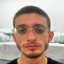

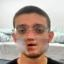

Iteration [1/3000], Loss: 1.8678428801559779


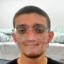

Iteration [151/3000], Loss: 0.38468220978047807


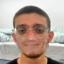

Iteration [301/3000], Loss: 0.35859144332994125


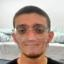

Iteration [451/3000], Loss: 0.34755640092282974


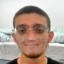

Iteration [601/3000], Loss: 0.3283337705921072


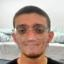

Iteration [751/3000], Loss: 0.32291756559591556


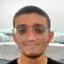

Iteration [901/3000], Loss: 0.3250723186082011


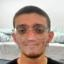

Iteration [1051/3000], Loss: 0.31984813894379294


KeyboardInterrupt: 

In [142]:
NUM_ITERATIONS = 3000

# load image
for i, (real_images, _) in enumerate(data_loader):
    img = real_images.cuda()
    break
    
masked_img = img * mask
original_blacked_img = img.cpu() * (1-org_mask)
original_blacked_img = original_blacked_img.cuda()
    
# show initial image
save_image(img, f"/kaggle/working/temp.png", nrow=5, normalize=True)
disp_img = Image.open(f"/kaggle/working/temp.png")
display(disp_img)

# Initialize the latent vector z with random noise
# noise = torch.randn((1, Generator.LATENT_DIM, 1, 1), dtype=torch.float32))
noise = (2 * torch.rand((1, Generator.LATENT_DIM, 1, 1), dtype=torch.float32)) - 1
noise = noise.cuda()
noise.requires_grad = True  # Ensure gradients are tracked


# Set up the optimizer for z
optimizer = torch.optim.Adam([noise], lr=0.1)

# Define the number of iterations for optimization

lambda_recon = 100.0
lambda_adv = 0.05

generator.eval()
discriminator.eval()

for iteration in range(NUM_ITERATIONS):
    optimizer.zero_grad()
    # Generate an image from the latent vector z
    generated_img = generator(noise)
    discriminator_output = discriminator(generated_img)
    # Compute the loss between the generated image and the corrupted image
    recon_loss = criterion(generated_img * mask, masked_img)
    
    adv_loss = bce_criterion(discriminator_output, torch.ones_like(discriminator_output))
    # Total loss
    loss = lambda_recon * recon_loss + lambda_adv * adv_loss
    # Backpropagate the loss
    loss.backward()

    # Update the latent vector z
    optimizer.step()

    # Print the loss every 1000 iterations
    if (iteration) % 150 == 0:
        # Apply the mask
        save_image(generated_img, f"/kaggle/working/source.jpg", nrow=5, normalize=True)
        save_image(original_blacked_img, f"/kaggle/working/bg.jpg", nrow=5, normalize=True)
        save_image(org_mask_cuda, f"/kaggle/working/mask.jpg", nrow=5, normalize=True)
        
        target_path = f"/kaggle/working/bg.jpg"
        source_path = f"/kaggle/working/source.jpg"
        mask_path = f"/kaggle/working/mask.jpg"
        blend_all(target_path, source_path, mask_path)

        disp_img = Image.open(f"/kaggle/working/output.jpg")
        display(disp_img)
        print(f"Iteration [{iteration+1}/{NUM_ITERATIONS}], Loss: {loss.item()}")
